# Set up your environment

Use the mlgeo enviroment from class
Install any missing packages
TODO: create new env file that includes all of these packages

In [28]:
# use mlgeo environment from class

!pip install h5py
!pip install keras
!pip install tensorflow
!pip install sklearn
!pip install seaborn
!pip install pydot
!pip install pydot graphviz     # for plotting model
!pip install librosa

#TODO write requirements.txt to include all of these

     |████████████████████████████████| 260 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 403 kB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 252 kB 22.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 22.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 43.9 MB 9.6 MB/s eta 0:00:011


In [13]:

import numpy as np
import h5py
import os, re, glob
import math
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, schedules
from keras import regularizers
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

### Optional - LFS

<div style="font-size: 14px;">
Input.npy is a Git LFS (Large File Storage) pointer to a large data file.

To download the file:

1. Install Git LFS (if you haven't already)
    ```python
    sudo apt-get install git-lfs
    ```
2. Initialize Git LFS in your repo (if you haven't already)
    ```python
    git lfs install
    ```
3. Track .npy Files with Git LFS
    ```python
    git lfs track "*.npy"
    ```

After you have cloned the repo, download the data file:

`    git lfs pull`


Note that the file is about 230MB. Running this locally will take a while. Using memory-map will save some time:

> The mmap_mode parameter in NumPy's np.load function allows you to memory-map a file, which means that the file is not fully loaded into memory. Instead, it is mapped to a portion of the virtual memory, allowing you to access parts of the file on demand. This is particularly useful for working with large files that do not fit into memory.
</div>

# Load data and split train-test

In [14]:
# download data from https://geofon.gfz-potsdam.de/doi/network/9F/2021

from sklearn.model_selection import train_test_split

print("beginning to load file...")

# memory-map the file, which is read-only by default
x = np.load("Input.npy", mmap_mode='r') # Seismic data from station NUPH should be cited as: doi:10.14470/4S7576570845

print("file loaded")

print("split data into training and testing sets")
train, test= train_test_split (x, test_size=0.2, train_size=0.8, random_state=46, shuffle=True)

print ('size-x='+str (x.shape), 'size-train='+str (train.shape),'size-test='+str (test.shape) )

beginning to load file...
file loaded
split data into training and testing sets
size-x=(2390, 96, 128) size-train=(1912, 96, 128) size-test=(478, 96, 128)


# Autoencoder architecture construction

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 96, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 48, 64, 8)      │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 32, 16)     │         1,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 16, 32)     │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 6, 8, 64)       │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 24)             │        73,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3072)           │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 12, 16, 32)     │        30,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 24, 32, 16)     │         7,696 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 48, 64, 8)      │         1,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 96, 128, 1)     │           281 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,929 (905.97 KB)

 Trainable params: 231,929 (905.97 KB)

 Non-trainable params: 0 (0.00 B)

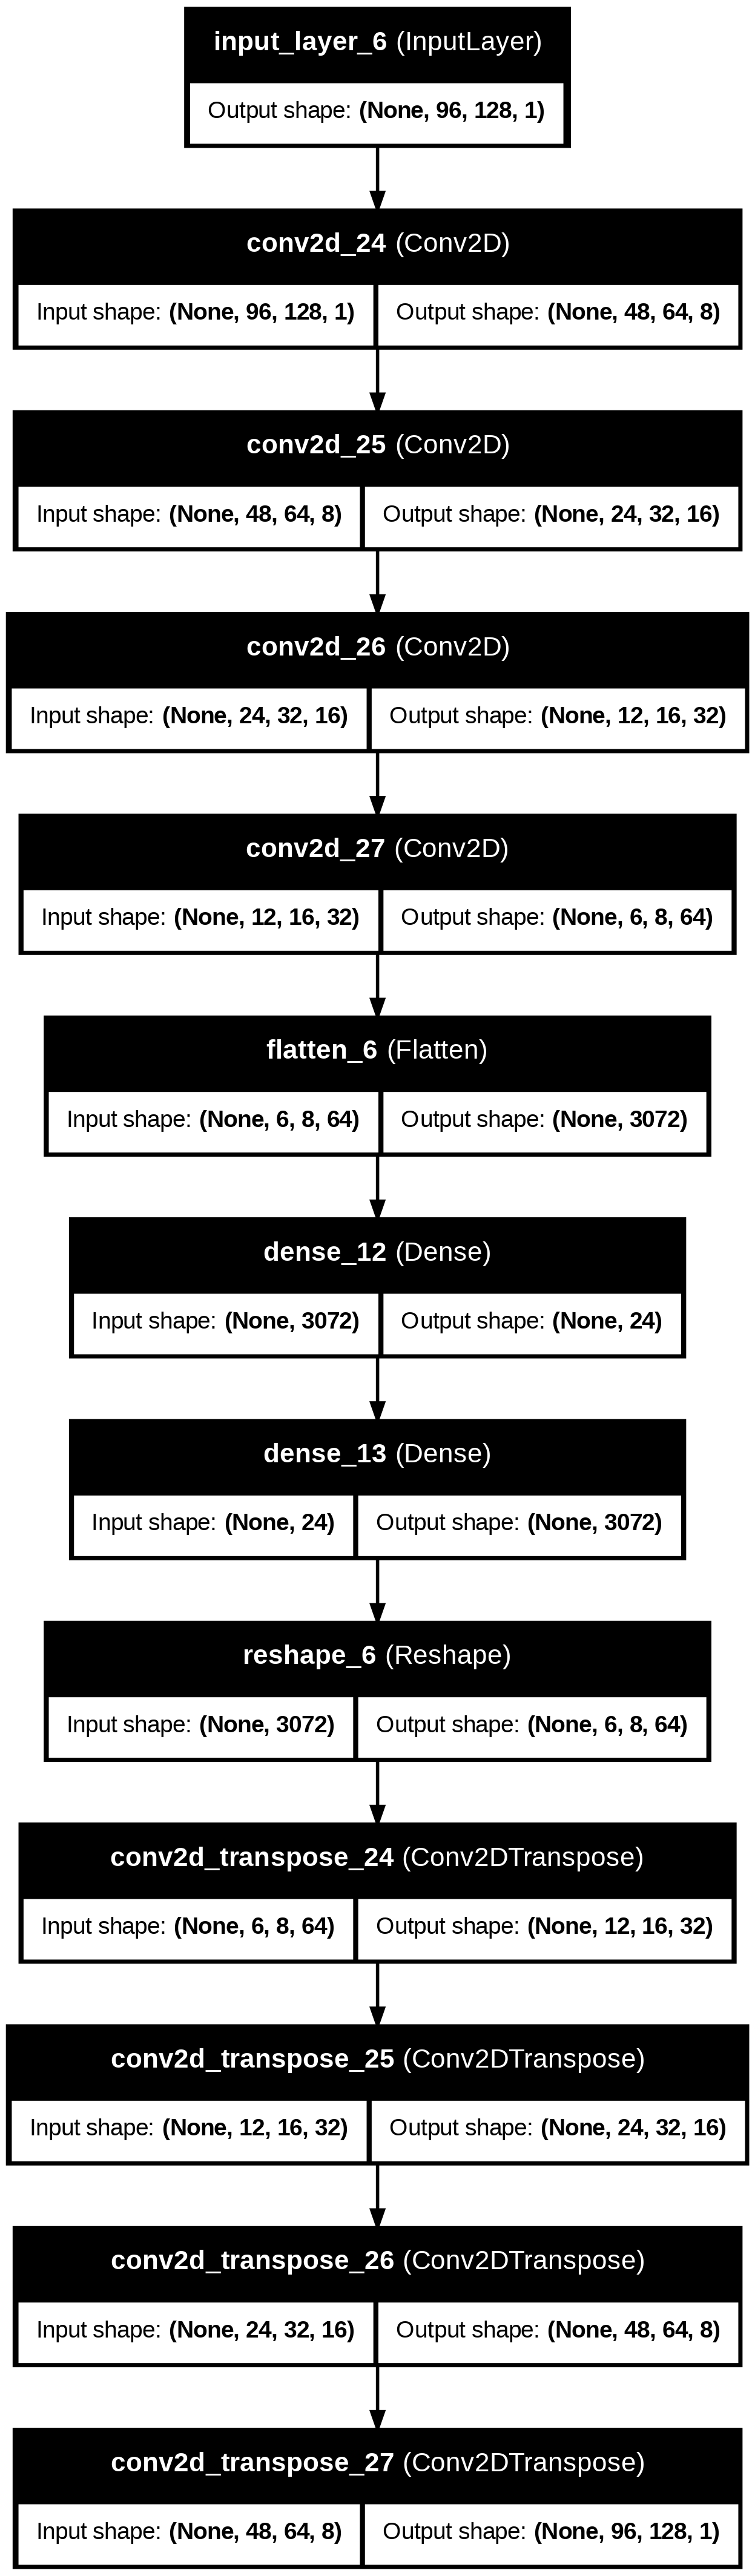

In [16]:
from numpy.random import seed
sd=46
seed(sd)
#import tensorflow
#import tensorflow as tf
tf.random.set_seed(sd)

from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Reshape
from keras.models import Model
# import tensorflow as tf
import keras.backend as K 

initializer = tf.keras.initializers.GlorotUniform(seed=sd)

inp = Input(shape=(96, 128, 1))  
e = Conv2D(8, (7, 5),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(inp)
e = Conv2D(16, (5, 3),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(e)
e = Conv2D(32, (5, 3),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(e)
e = Conv2D(64, (5, 3),strides=[2,2], activation='elu' , kernel_initializer=initializer, padding='same')(e)

# use tf.keras.backend.int_shape to get the shape of a tensor
shape_before_flattening = tf.keras.backend.int_shape(e)
encoded1 = Flatten()(e)

encoded2= Dense (24, activation='elu')(encoded1)
fc= Dense (3072, activation='elu')(encoded2)

d = Reshape(shape_before_flattening[1:])(fc)
    
d = Conv2DTranspose(32, (5, 3), strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(d)
d = Conv2DTranspose(16, (5, 3), strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(d)
d = Conv2DTranspose(8, (5, 3),strides=[2,2] , activation='elu', kernel_initializer=initializer, padding='same')(d)
decoded = Conv2DTranspose(1, (7, 5),strides=[2,2] , activation='linear', kernel_initializer=initializer, padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded2, name='encoder')

# use tf.keras.utils.plot_model to visualize the model
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

autoencoder.summary()

# Specify the full path for the output file
output_path = os.path.join(os.getcwd(), 'autoencoder.png')

TODO: make this display more interesting
try:
    plot_model(autoencoder, to_file=output_path, show_shapes=True, show_layer_names=True)
    display(Image(filename=output_path))
except Exception as e:
    print(f"Error creating or displaying model plot: {e}")

### Optional: display the image with TensorBoard

In [8]:
from tensorflow.keras.callbacks import TensorBoard

# Use TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Train the model
autoencoder.fit(X_train, Y_train, epochs=10, callbacks=[tensorboard_callback])

# Launch TensorBoard from the terminal
# tensorboard --logdir=./logs

NameError: name 'X_train' is not defined

# Initial training phase: Pretraining the autoencoder

In [21]:
# raise number to 500 during actual run
# 50 is faster, so use it for setup
NUM_OF_EPOCHS = 500

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate= 0.001,
    decay_steps=1000,
    decay_rate=0.5)

### Adapting the learning rate of the optimizer using an exponential decay schedule

optimizer = Adam(learning_rate=lr_schedule)   

es = EarlyStopping( monitor='val_loss', mode='min', verbose=1, patience=30), CSVLogger('pretrain_log.csv')

autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.fit(train, train, batch_size=32, epochs=NUM_OF_EPOCHS ,validation_data=(test, test), callbacks=es)

Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.5792 - val_loss: 0.6407
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.5832 - val_loss: 0.6412
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.5731 - val_loss: 0.6314
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.5677 - val_loss: 0.6373
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.5680 - val_loss: 0.6257
Epoch 6/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.5609 - val_loss: 0.6277
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.5595 - val_loss: 0.6283
Epoch 8/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.5598 - val_loss: 0.6252
Epoch 9/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.5572 - val_loss: 0.6297
Epoch 10/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.5550 - val_loss: 0.6230
Epoch 11/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.5509 - val_loss: 0.6224
Epoch 12/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step

# Evaluate autoencoder reconstruction

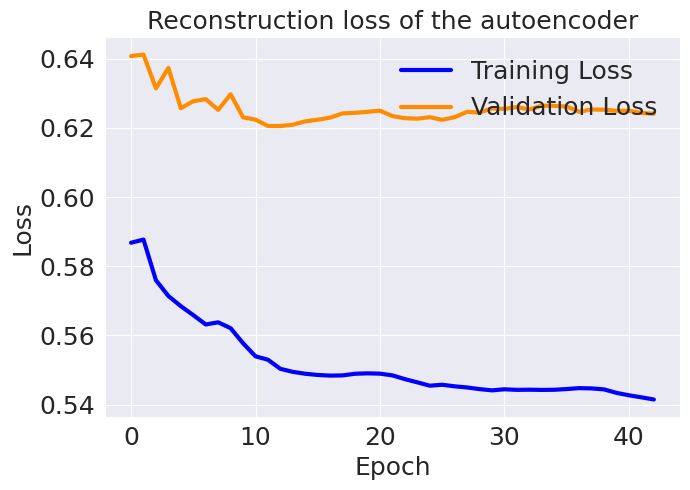

In [22]:
import pandas as pd
df = pd.read_csv('pretrain_log.csv')
fig= plt.figure(figsize=(7, 5))
plt.plot(df['epoch'],df['loss'], color='b',label='Training Loss', linewidth=3.0)
plt.plot(df['epoch'],df['val_loss'], color='darkorange',label='Validation Loss', linewidth=3.0)

plt.ylabel('Loss', fontsize= 18)
plt.xlabel('Epoch', fontsize= 18)
plt.title('Reconstruction loss of the autoencoder', fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)

plt.legend(loc= 1, frameon= False, fontsize= 18)
plt.tight_layout()
plt.show ()
fig.savefig ( 'ReconstructionLoss.png', dpi= 100)

In [26]:
### Save the model

# original
# autoencoder.save ('autoencoder-model')

autoencoder.save('autoencoder-model.keras')

### Autoencoder input-output visualization

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


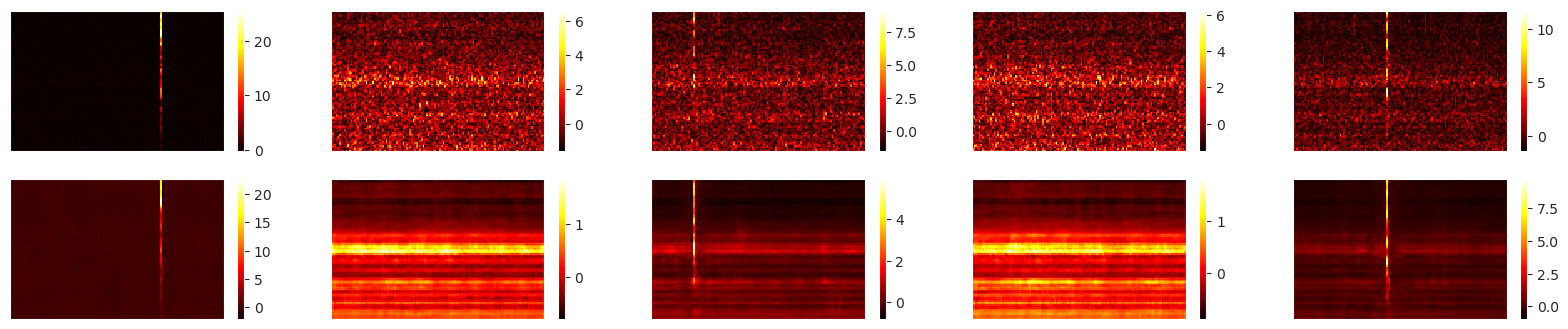

In [29]:
decoded_imgs = autoencoder.predict(x)

import librosa
import librosa.display

s=300
e=305
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    librosa.display.specshow(x[i,:,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(decoded_imgs[i,:,:,0], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Kmeans clustering based on extracted features from the autoencoder

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


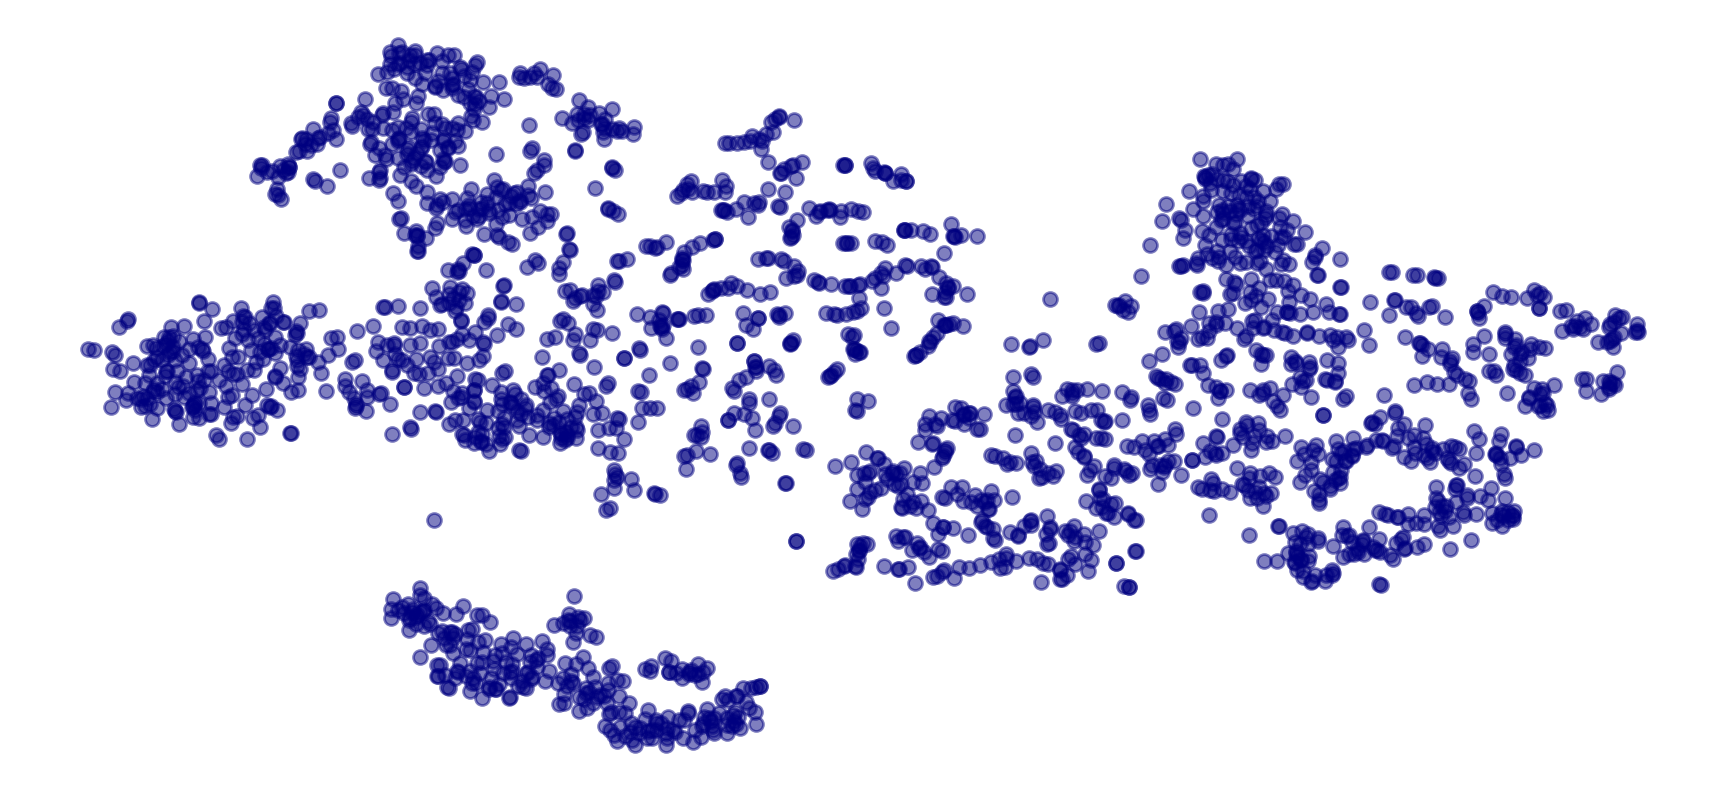

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [43]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1, random_state=46, n_init=20).fit(encoder.predict(x))
y = kmeans.predict(encoder.predict(x))

def plotter(S, y):
    '''
    function to visualize the outputs of t-SNE
    '''
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    plt.scatter(S[y == 0, 0], S[y == 0, 1],color='navy', alpha=.5, lw=lw, s=100)
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n1', dpi= 100,bbox_inches = "tight")

    return f, ax

# TSNE (t-distributed Stochastic Neighbor Embedding)
enc = encoder.predict(x)

redu = TSNE(random_state=123).fit_transform(enc)
plotter(redu, y) 


TODO: this plot doesn't look like the paper's plot

# Determining optimal number of clusters

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━

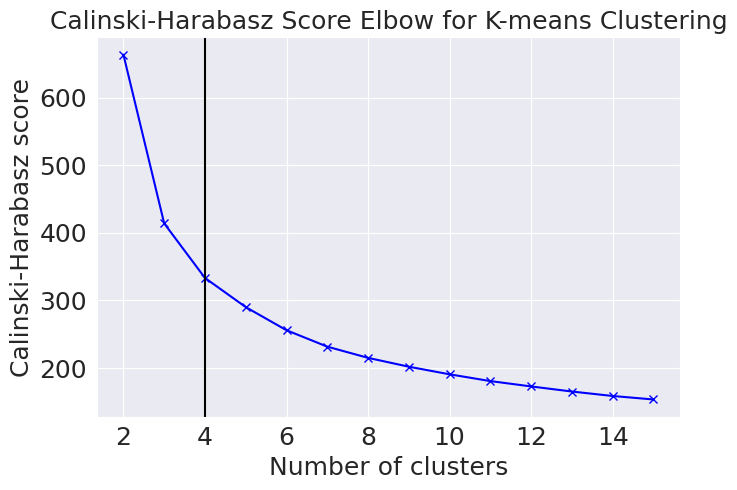

In [36]:
from sklearn.metrics import calinski_harabasz_score
cal = []
K = range(2,16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoder.predict(x))
    labelskm = kmeans.predict(encoder.predict(x))
    cal.append(calinski_harabasz_score(encoder.predict(x), labelskm))
fig= plt.figure(figsize=(7, 5))
plt.plot(K, cal, 'bx-')
plt.xlabel('Number of clusters',fontsize= 18)
plt.ylabel('Calinski-Harabasz score',fontsize= 18)
plt.title('Calinski-Harabasz Score Elbow for K-means Clustering',fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)
plt.axvline(x = 4, color = 'black')
plt.tight_layout()
plt.show()
fig.savefig ( 'Calinski score.png', dpi=100)

# T-sne visualizations of seismic event clusters in feature domain after pretraining

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


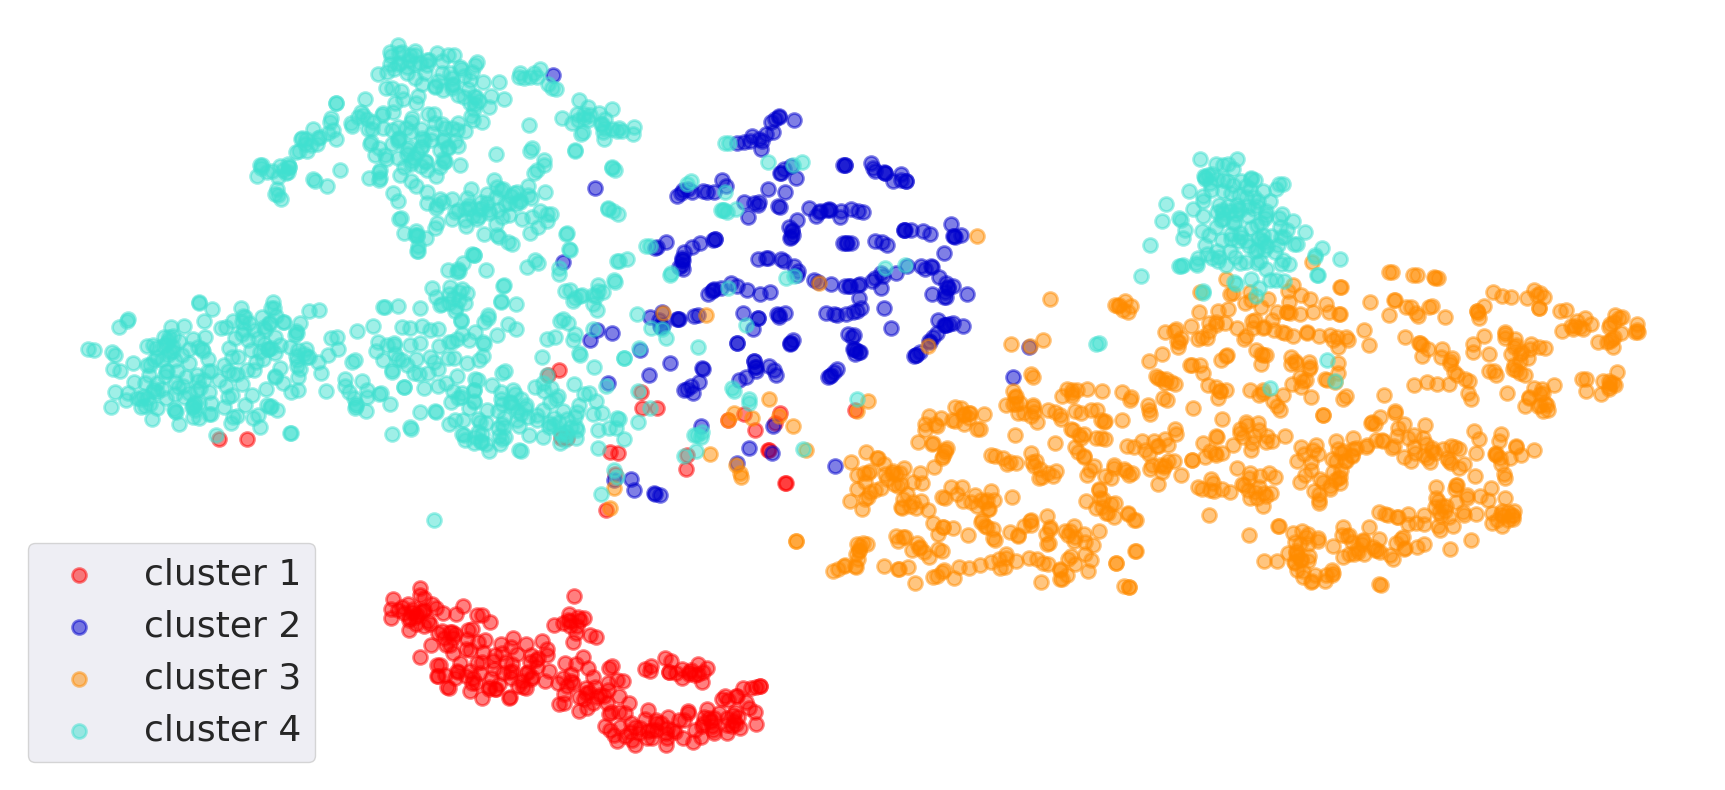

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [37]:
kmeans = KMeans(n_clusters=4, random_state=46, n_init=20).fit(encoder.predict(x))
y = kmeans.predict(encoder.predict(x))

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = [ 'red', 'mediumblue','darkorange','turquoise','lime', 'turquoise', 'darkorange','lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n4', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoder.predict(x)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
plotter(redu, y, target_names) 


# Loading the pre-trained model

In [39]:
from tensorflow.keras.models import load_model
autoencoder = load_model("autoencoder-model.keras")

/home/jen/anaconda3/envs/mlgeo/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 41 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
import keras.backend as K
get_all_layer_outputs = K.function([autoencoder.layers[0].input],
                                  [l.output for l in autoencoder.layers[1:]])

layer_output = get_all_layer_outputs([x]) # return the same thing

AttributeError: module 'keras.backend' has no attribute 'function'

In [25]:
n_clusters=4

# Integrating clustering layer into autoencoder bottelneck

In [ ]:
from numpy.random import seed
sd=46
seed(sd)
import tensorflow
import tensorflow as tf
tensorflow.random.set_seed(sd)

initializer = tf.keras.initializers.GlorotUniform(seed=sd)

#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer , name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
    
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(autoencoder.layers[6].output)
model = Model(inputs=autoencoder.layers[0].output, outputs=clustering_layer)
model.compile(loss='kld', loss_weights=0.1,  optimizer=SGD(learning_rate=0.01,  momentum=0.9))

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
#Image(filename='model.png')

In [29]:
### Initializing the weights using Kmean and assigning them to the model

kmeans = KMeans(n_clusters=n_clusters,  random_state=46, n_init=20)
y_pred = kmeans.fit_predict(layer_output[5])
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# Finetuning pre-trained model parameters

In [ ]:
## parameters for the finetuning

batch_size=32 
tol = 0.0001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter = 50000 
update_interval = 200 
index_array = np.arange(x.shape[0])

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        loss = np.round(loss, 5)
        print('Iter %d: ' % (ite), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break
        
        IN = layer_output[5]
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0  


In [31]:
import keras.backend as K
get_all_layer_outputs = K.function([autoencoder.layers[0].input],
                                  [l.output for l in autoencoder.layers[1:]])

layer_output = get_all_layer_outputs([x]) # return the same thing

# T-sne visualizations of seismic event clusters in feature domain after finetuning

In [ ]:
y=y_pred

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['red', 'mediumblue','darkorange','turquoise', 'lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=0.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tsne-km-n4-ft.png', dpi= 100,bbox_inches = "tight")
    
    return f, ax

enc = layer_output[5]
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = [ 'Earthquakes (EQ)','Continuous tremors 1 (CT1)', 'Episodic tremors (ET)', 'Continuous tremors 2 (CT2)' ]
plotter(redu, y, target_names) 


In [33]:
### Save the labels
np.savetxt('Km-n4-ft.txt', y, fmt='%i', delimiter=',')

# Change the order of the cluster numbers (just for a nice representation)

with open('km-n4-ft.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('3', 'x')
filedata = filedata.replace('2', '3')
filedata = filedata.replace('1', '2')
filedata = filedata.replace('0', '1')
filedata = filedata.replace('x', '0')

# Re-write the output
with open('Km-n4-ft.txt', 'w') as file:
  file.write(filedata)

### Visualizing cluster changes across time

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

y= np.loadtxt ('km-n4-ft.txt')
fig= plt.figure(figsize=(18, 4))
ax = fig.add_subplot()
x1=list(range(0,2390))
colors = ['red', 'mediumblue','darkorange','turquoise']
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
ax.scatter (x1, y, c=y, cmap=cmap, s= 30, alpha=0.2)
ax.set_yticks ([0, 1, 2,3])
ax.set_yticklabels (['EQ','CT1', 'ET','CT2'], fontsize=18)
plt.ylabel('Clusters', fontsize= 18)

ax.set_xticks ([0,175,417,708,996,1117,1425,1782,2142,2390])
ax.set_xticklabels (['12 March','19 March','30 March','15 April','27 April','2 May','15 May','30 May','14 June','24 June'], fontsize=16)
ax.axvline (x=174, linewidth=4, color='black')
ax.axvline (x=996, linewidth=4, color='black')
ax.axvline (x=2127, linewidth=4, color='black')

plt.xlim (0,2390)
#plt.xlim (980,1020)
plt.tight_layout()
fig.savefig ( 'Temporal Cluster Changes.png', dpi= 100)

# Cluster-wise autoencoder input-output visualization

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec

autoencoder = load_model("autoencoder-model")
import keras.backend as K
get_all_layer_outputs = K.function([autoencoder.layers[0].input],
                                  [l.output for l in autoencoder.layers[1:]])

layer_output = get_all_layer_outputs([x]) # return the same thing
decoded_imgs = autoencoder.predict(x)

fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(x[43,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(x[44,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax2.set(ylabel=None)

fig.suptitle ('Cluster EQ', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(x[45,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[43,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[44,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 18)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize=18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[45,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)



plt.tight_layout()    
plt.savefig ('In&out-EQ.png', dpi=100, bbox_inches = "tight")
plt.show()

In [ ]:
fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(x[353,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(x[354,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster CT1', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(x[355,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[353,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[354,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 18)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[355,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-CT1.png', dpi=100)
plt.show()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(x[1169,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(x[1170,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster ET', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(x[1171,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[1169,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[1170,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 20)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[1171,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-ET.png', dpi=100)
plt.show()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(x[2342,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(x[2343,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster CT2', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(x[2344,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[2342,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[2343,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 20)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[2344,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-CT2.png', dpi=100)
plt.show()